In [1]:
import ants
import numpy as np
import nibabel as nib
import nilearn.plotting
import os
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import scipy.stats
import json

from motcorr_utils import (
    compute_timeseries_similarity,
    plot_motpars,
    get_motion_parameters_from_transforms
)
basedir = '/Users/poldrack/data_unsynced/brainsss/ants_example_data'
basedir = '/data/brainsss/ants_example_data'

In [2]:
def r_to_z(r):
    # fisher transform
    z=0.5*np.log((1.0+r)/(1.0-r))
    if np.isinf(z) or np.isnan(z):
        return 0
    return z

# use z transform since results are in the tails
def compute_similarity_to_mean(img, meanimg, 
                               mask):
    imgdata = img[mask > 0].flatten()
    meandata = meanimg[mask > 0].flatten()
    assert imgdata.shape == meandata.shape
    return r_to_z(np.corrcoef(imgdata, meandata)[0, 1])


## Setup data
use the um/mm data to address issues with ants

In [3]:
origfile = os.path.join(basedir, 'series-tdtomato_size-um_units-mm.nii')
meanfile = os.path.join(basedir, 'series-tdtomato_size-um_units-mm_mean.nii')

origimg = nib.load(origfile)
meanimg = nib.load(meanfile)

print(origimg.affine)
print(origimg.header.get_xyzt_units())

[[2.61120129 0.         0.         0.        ]
 [0.         2.61114621 0.         0.        ]
 [0.         0.         5.         0.        ]
 [0.         0.         0.         1.        ]]
('mm', 'sec')


In [4]:
# create ANTs images
orig_ants = ants.from_nibabel(origimg)
mean_ants = ants.from_nibabel(meanimg)

In [5]:
# get mask
meandata = meanimg.get_fdata()
mean_ants = ants.from_nibabel(meanimg)

thresh = 200 # by eyeball
# 3d mask
maskdata = (meandata > thresh).astype('int')
maskimg = nib.Nifti1Image(maskdata, header=meanimg.header, affine=meanimg.affine)

# extract brain
mask_ants = ants.label_clusters(
    ants.from_nibabel(maskimg),
    min_cluster_size=50000)
maskimg = mask_ants.to_nibabel()

# get 4d mask and mean
mask4d = nib.Nifti1Image(np.zeros(origimg.shape), 
                         affine=origimg.affine, header=origimg.header)
mean4d = nib.Nifti1Image(np.zeros(origimg.shape), 
                         affine=origimg.affine, header=origimg.header)
for i in range(origimg.shape[-1]):
    mask4d.dataobj[:, :, :, i] = maskimg.dataobj
    mean4d.dataobj[:, :, :, i] = meanimg.dataobj

mask_4d_ants = ants.from_nibabel(mask4d)
mean_4d_ants = ants.from_nibabel(mean4d)
np.sum(mask_4d_ants[:,:,:, 0])

850576.0

Plot mask and mean as reality check

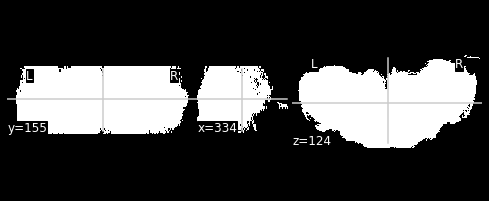

In [6]:
nilearn.plotting.plot_anat(ants.slice_image(mask_4d_ants, axis=3, idx=40).to_nibabel(),
                           vmin=0, vmax=1)

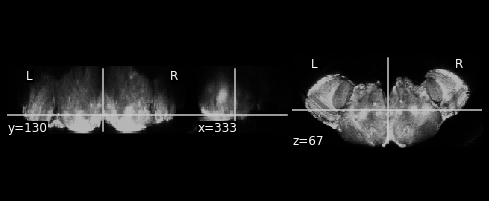

In [7]:
nilearn.plotting.plot_anat(ants.slice_image(mean_4d_ants, axis=3, idx=40).to_nibabel())


## Compare different registration methods

We will compare these methods in terms of the relative improvement in 
similarity to the mean image. For nonlinear methods we will also compare the roughness of the resulting warps.

In [8]:

moco_results = {}

moco_results = {'Rigid': ants.motion_correction(
    image=orig_ants,
    fixed=mean_ants,
    verbose=True,
    type_of_transform='Rigid')}

moco_results['Affine'] = ants.motion_correction(
    image=orig_ants,
    fixed=mean_ants,
    verbose=True,
    type_of_transform='Affine')

Progress:
0%.Done
Progress:
0%.Done


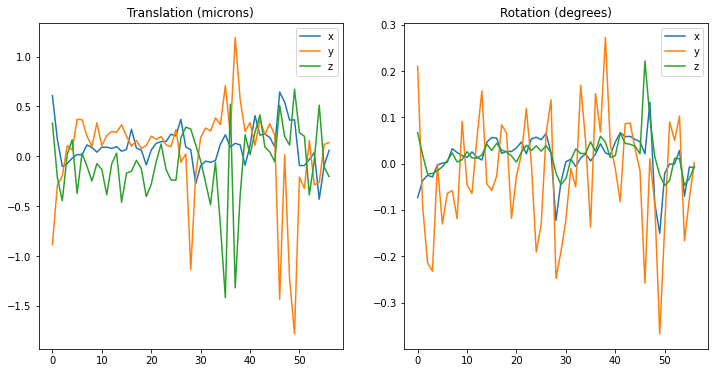

In [9]:
# plot motion parameters
motpars = {}
motpars['Rigid'] = get_motion_parameters_from_transforms(
    moco_results['Rigid']['motion_parameters'])[1]
plot_motpars(motpars['Rigid'])

In [10]:
mean_similarity = {}

for model in ['Rigid', 'Affine']:
    mean_similarity[model] = compute_similarity_to_mean(
        moco_results[model]['motion_corrected'],
        mean_4d_ants, mask_4d_ants)

# also compute similarity of orig data to mean, for comparison
mean_similarity['orig'] = compute_similarity_to_mean(
    orig_ants,
    mean_4d_ants,
    mask_4d_ants)



In [11]:
mean_similarity

{'Rigid': 2.112899356723075,
 'Affine': 2.1526107322610173,
 'orig': 1.9275498005445286}

### Test SyN at various levels of regularization

In [22]:
transform = 'SyN' # 'ElasticSyN'

for flow_sigma in [0, 1, 2, 3]:
    for total_sigma in [0, 1, 2, 3]:
        model = f'{transform}_flowsigma-{flow_sigma}_totalsigma-{total_sigma}'
        print('running model:', model)
        moco_results[model] = ants.motion_correction(
            image=orig_ants,
            fixed=mean_ants,
            verbose=True,
            type_of_transform=transform,
            flow_sigma=flow_sigma,
            total_sigma=total_sigma)
        mean_similarity[model] = compute_similarity_to_mean(
            moco_results[model]['motion_corrected'],
            mean_4d_ants,
            mask_4d_ants)
        motpars[model] = get_motion_parameters_from_transforms(
            moco_results[model]['motion_parameters'])[1]

running model: SyN_flowsigma-0_totalsigma-0
Progress:
0%.Done
running model: SyN_flowsigma-0_totalsigma-1
Progress:
0%.Done
running model: SyN_flowsigma-0_totalsigma-2
Progress:
0%.Done
running model: SyN_flowsigma-0_totalsigma-3
Progress:
0%.Done
running model: SyN_flowsigma-1_totalsigma-0
Progress:
0%.Done
running model: SyN_flowsigma-1_totalsigma-1
Progress:
0%.Done
running model: SyN_flowsigma-1_totalsigma-2
Progress:
0%.Done
running model: SyN_flowsigma-1_totalsigma-3
Progress:
0%.Done
running model: SyN_flowsigma-2_totalsigma-0
Progress:
0%.Done
running model: SyN_flowsigma-2_totalsigma-1
Progress:
0%.Done
running model: SyN_flowsigma-2_totalsigma-2
Progress:
0%.Done
running model: SyN_flowsigma-2_totalsigma-3
Progress:
0%.Done
running model: SyN_flowsigma-3_totalsigma-0
Progress:
0%.Done
running model: SyN_flowsigma-3_totalsigma-1
Progress:
0%.Done
running model: SyN_flowsigma-3_totalsigma-2
Progress:
0%.Done
running model: SyN_flowsigma-3_totalsigma-3
Progress:
0%.Done


In [23]:
# compute similarity to mean for each model
# quantified as Fisher z-transformed correlation


for img in moco_results:
    if img not in mean_similarity:
        mean_similarity[img] = compute_similarity_to_mean(
            moco_results[img]['motion_corrected'],
            mean_4d_ants,
            mask_4d_ants)

    print(f'{img}: {np.mean(mean_similarity[img]):.3f}')

Rigid: 2.113
Affine: 2.153
SyN_flowsigma-0_totalsigma-0: 2.265
SyN_flowsigma-0_totalsigma-1: 2.241
SyN_flowsigma-0_totalsigma-2: 2.224
SyN_flowsigma-0_totalsigma-3: 2.213
SyN_flowsigma-1_totalsigma-0: 2.296
SyN_flowsigma-1_totalsigma-1: 2.259
SyN_flowsigma-1_totalsigma-2: 2.249
SyN_flowsigma-1_totalsigma-3: 2.239
SyN_flowsigma-2_totalsigma-0: 2.298
SyN_flowsigma-2_totalsigma-1: 2.259
SyN_flowsigma-2_totalsigma-2: 2.248
SyN_flowsigma-2_totalsigma-3: 2.242
SyN_flowsigma-3_totalsigma-0: 2.296
SyN_flowsigma-3_totalsigma-1: 2.261
SyN_flowsigma-3_totalsigma-2: 2.249
SyN_flowsigma-3_totalsigma-3: 2.242


In [24]:
# save transform files
import json

transforms = {}
for model in moco_results:
    transforms[model] = moco_results[model]['motion_parameters']

with open('transform_files.json', 'w') as f:
    json.dump(transforms, f)

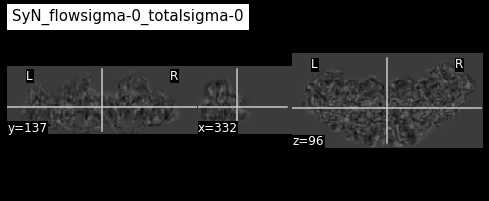

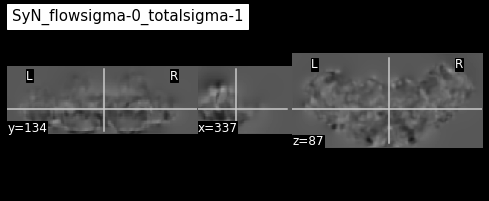

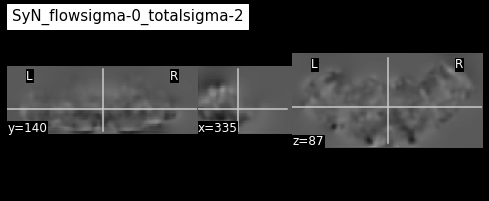

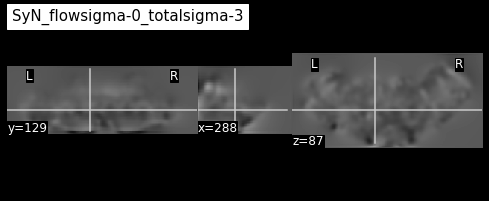

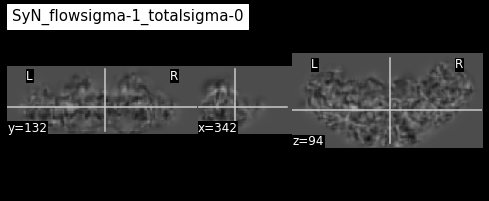

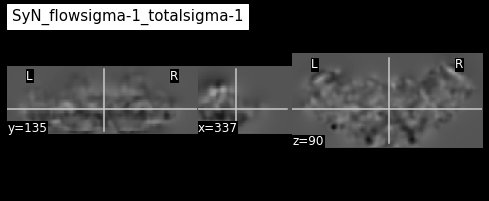

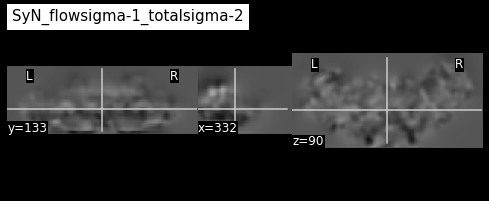

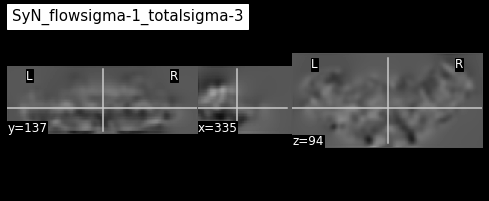

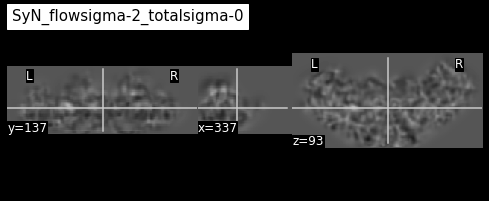

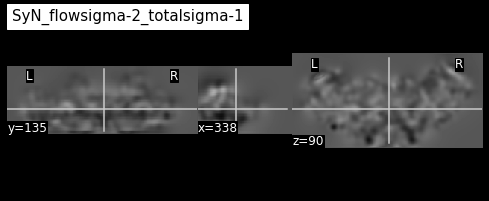

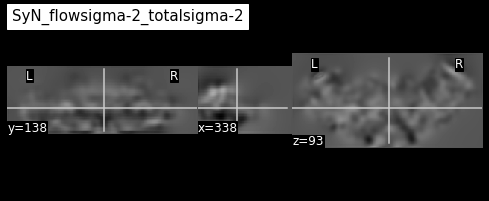

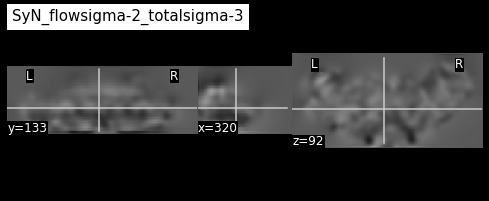

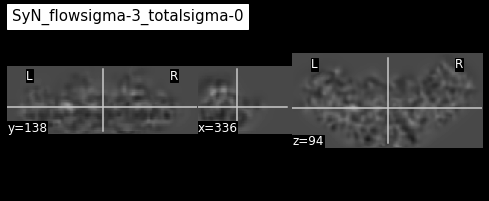

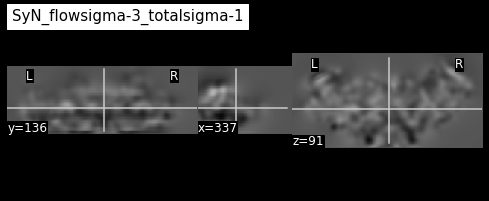

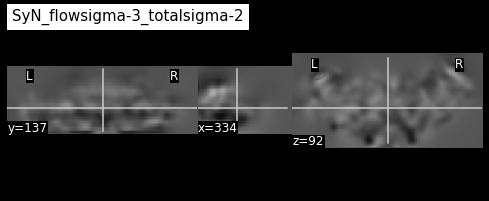

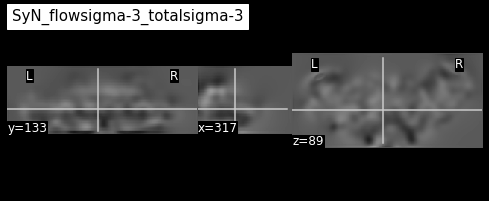

In [25]:
# display warp fields for each model for a high-motion timepoint

high_motion_timepoint = np.argmax(moco_results['Rigid']['FD'])

warpimgs = {}

for model in moco_results:
    if model in ['Rigid', 'Affine']:
        continue
    warpimgs[model] = moco_results[model]['motion_parameters'][high_motion_timepoint][0]
    jd = ants.create_jacobian_determinant_image(mean_ants, 
        warpimgs[model]).to_nibabel()
    nilearn.plotting.plot_anat(jd, title=model)

Quantify the relative smoothness of the warps across regularlization parameters.  To do this, we compute the laplacian (2nd spatial derivative) of the jacbobian determinant of the warp field, and the take the mean of its absolute value (since we don't care about the direction, only the magnitude).

In [26]:
def get_warp_laplacian(warpfile, meanimg,  maskimg):
    """quantify warp roughness using the mean
    absolute laplacian (2nd spatial derivative) of 
    the jacobian determinant of the warp field"""
    warpimg = ants.image_read(warpfile)
    jd = ants.create_jacobian_determinant_image(
        meanimg, warpimg).to_nibabel()
    jd = jd.get_fdata()[maskimg[:,:,:] > 0]
    jd = jd / np.max(jd)

    laplacian = ndi.laplace(jd)
    return np.average(np.absolute(laplacian))

In [27]:
roughness = {}
for model in transforms:
    if model.find('SyN') == -1:
        continue
    if model not in roughness:
        print(model)
        roughness[model] = 0
        for timepoint, transform in enumerate(transforms[model]):
            warpimg = transform[0]
            roughness[model] += get_warp_laplacian(warpimg, mean_ants, mask_ants) / len(
                transforms[model])
    print(model, roughness[model])

SyN_flowsigma-0_totalsigma-0
SyN_flowsigma-0_totalsigma-0 0.019436113008668
SyN_flowsigma-0_totalsigma-1
SyN_flowsigma-0_totalsigma-1 0.0034685309593883384
SyN_flowsigma-0_totalsigma-2
SyN_flowsigma-0_totalsigma-2 0.0019843216608112016
SyN_flowsigma-0_totalsigma-3
SyN_flowsigma-0_totalsigma-3 0.001495631734580967
SyN_flowsigma-1_totalsigma-0
SyN_flowsigma-1_totalsigma-0 0.012173064799143866
SyN_flowsigma-1_totalsigma-1
SyN_flowsigma-1_totalsigma-1 0.003650207408064375
SyN_flowsigma-1_totalsigma-2
SyN_flowsigma-1_totalsigma-2 0.002771454778639598
SyN_flowsigma-1_totalsigma-3
SyN_flowsigma-1_totalsigma-3 0.0022720318714188697
SyN_flowsigma-2_totalsigma-0
SyN_flowsigma-2_totalsigma-0 0.008943045437184032
SyN_flowsigma-2_totalsigma-1
SyN_flowsigma-2_totalsigma-1 0.0032095608979657553
SyN_flowsigma-2_totalsigma-2
SyN_flowsigma-2_totalsigma-2 0.002603434995003146
SyN_flowsigma-2_totalsigma-3
SyN_flowsigma-2_totalsigma-3 0.0023133288073779795
SyN_flowsigma-3_totalsigma-0
SyN_flowsigma-3_total

In [28]:
# plot roughness in relation to regularization parameters

import pandas as pd

roughness_elastic = {k:v for k,v in roughness.items() 
    if k.find('SyN_flow') == 0}

df = pd.DataFrame({
    'flowsigma': None,
    'totalsigma': None,
    'roughness': None,
    'mean_similarity': None}, 
    index=roughness_elastic.keys())
for k, v in roughness_elastic.items():
    print(k, v)
    df.loc[k, 'flowsigma'] = float(k.split('_')[-2].split('-')[1])
    df.loc[k, 'totalsigma'] = float(k.split('_')[-1].split('-')[1])
    df.loc[k, 'roughness'] = v
    df.loc[k, 'mean_similarity'] = mean_similarity[k]

SyN_flowsigma-0_totalsigma-0 0.019436113008668
SyN_flowsigma-0_totalsigma-1 0.0034685309593883384
SyN_flowsigma-0_totalsigma-2 0.0019843216608112016
SyN_flowsigma-0_totalsigma-3 0.001495631734580967
SyN_flowsigma-1_totalsigma-0 0.012173064799143866
SyN_flowsigma-1_totalsigma-1 0.003650207408064375
SyN_flowsigma-1_totalsigma-2 0.002771454778639598
SyN_flowsigma-1_totalsigma-3 0.0022720318714188697
SyN_flowsigma-2_totalsigma-0 0.008943045437184032
SyN_flowsigma-2_totalsigma-1 0.0032095608979657553
SyN_flowsigma-2_totalsigma-2 0.002603434995003146
SyN_flowsigma-2_totalsigma-3 0.0023133288073779795
SyN_flowsigma-3_totalsigma-0 0.007159967252866265
SyN_flowsigma-3_totalsigma-1 0.0030512854746235873
SyN_flowsigma-3_totalsigma-2 0.0024735856135894257
SyN_flowsigma-3_totalsigma-3 0.002307488655246493


<AxesSubplot:xlabel='flowsigma', ylabel='roughness'>

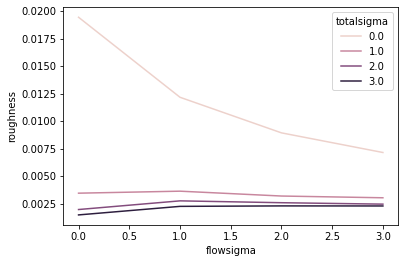

In [29]:
import seaborn as sns
sns.set_palette('viridis')

sns.lineplot(x='flowsigma', y='roughness', hue='totalsigma', 
    data=df)

<AxesSubplot:xlabel='totalsigma', ylabel='roughness'>

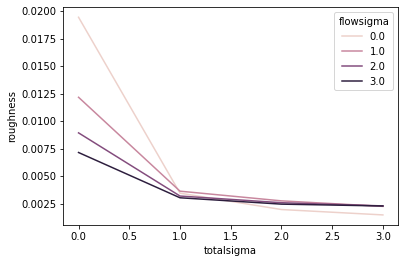

In [30]:
sns.lineplot(hue='flowsigma', y='roughness', x='totalsigma', 
    data=df)

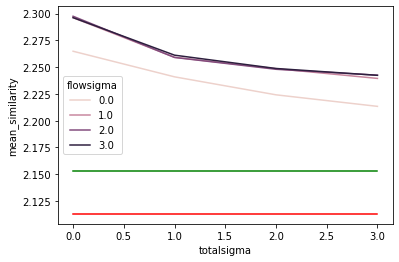

In [39]:
sns.lineplot(hue='flowsigma', y='mean_similarity', x='totalsigma', 
    data=df)
plt.plot([0, 3], [mean_similarity['Rigid'], mean_similarity['Rigid']], color='red')
plt.plot([0, 3], [mean_similarity['Affine'], mean_similarity['Affine']], color='green')